In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

Final entry in db:  2017-08-23
Date one year ago from :  2016-08-23


Index(['Date', 'Precipitation'], dtype='object')

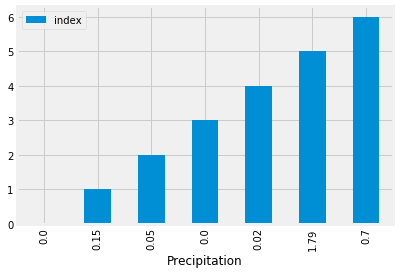

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
measurement_12 = session.query(Measurement).filter(Measurement.date).order_by(Measurement.date.desc()).limit(12).all()
# for measure in measurement_12:
#     print(measure.date)
# Calculate the date 1 year ago from the last data point in the database
date_one_year_ago = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print("Final entry in db: ",*date_one_year_ago)

d1yr = dt.date(2017,8,23) - dt.timedelta(days = 365)
print("Date one year ago from : ", d1yr)
# Perform a query to retrieve the data and precipitation scores
q_date = []
q_prcp = []
prcp_data = session.query(Measurement).filter(Measurement.date == d1yr)
for prcp in prcp_data:
    q_date.append(prcp.date)
    q_prcp.append(prcp.prcp)
# Save the query results as a Pandas DataFrame and set the index to the date column
q_results = pd.DataFrame({"Date":q_date,"Precipitation":q_prcp}).replace(np.nan,0)

# Sort the dataframe by date
q_results_sorted_1 = q_results.sort_values(['Date'],ascending=[True])
# Use Pandas Plotting with Matplotlib to plot the data
q_results_sorted_1.reset_index().plot(x ='Precipitation', y='index',kind = 'bar')

q_results_sorted_1.columns

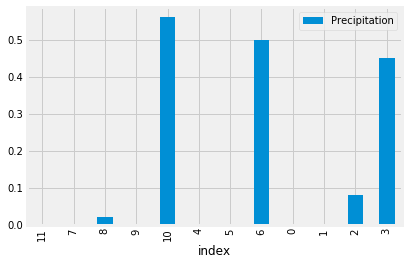

In [14]:
q_date = []
q_prcp = []

measurement_12 = session.query(Measurement).filter(Measurement.date).order_by(Measurement.date.desc()).limit(12).all()
for measure in measurement_12:
    q_date.append(measure.date)
    q_prcp.append(measure.prcp)

q_results = pd.DataFrame({"Date":q_date,"Precipitation":q_prcp}).replace(np.nan,0)
q_results_sorted = q_results.sort_values(['Date'],ascending=[True])
q_results_sorted.reset_index().plot(x ='index', y='Precipitation',kind = 'bar')


![precipitation](Images/precipitation.png)

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measure_p = []
measure_prcp = session.query(Measurement).filter(Measurement.prcp)
for m in measure_prcp:
    measure_p.append(m.prcp)

m_prcp_df = pd.DataFrame({'precipitaion':measure_p})
m_prcp_df.describe()

,precipitaion
count,9918.000000
mean,0.293217
std,0.601825
min,0.010000
25%,0.030000
50%,0.090000
75%,0.290000
max,11.530000


![describe](Images/describe.png)

In [16]:
# Design a query to show how many stations are available in this dataset?
station = session.query(Measurement.station,Station.station).filter(Measurement.station == Station.station)
station.count()

19550

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query()

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
